# Import Modules

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.nn import functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import copy
import random
import time
import pandas as pd
plt.ion()   # interactive mode

# Set seed for reproducability

In [2]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)



# Load Images

In [2]:
#data transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=(-20, 20)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
import splitfolders
splitfolders.ratio('DR_6c_lex', output="split_6c_lex", seed=1337, ratio=(.8, 0.2))

In [3]:
data_dir = 'split_6c_lex/'
data_dir

'split_6c_lex/'

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("Dataset size for training data: ", dataset_sizes['train'])
print("Dataset size for validation data: ", dataset_sizes['val'])

class_names = image_datasets['train'].classes
print("Class names: ", class_names)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset size for training data:  633
Dataset size for validation data:  168
Class names:  ['dent', 'dent,glass_shatter', 'dent,glass_shatter,head_lamp,scratch', 'dent,glass_shatter,head_lamp,scratch,tail_lamp', 'dent,glass_shatter,scratch', 'dent,head_lamp', 'dent,head_lamp,scratch', 'dent,scratch', 'dent,scratch,tail_lamp', 'dent,tail_lamp', 'glass_shatter', 'head_lamp', 'head_lamp,scratch', 'scratch', 'scratch,tail_lamp', 'tail_lamp', 'unknown']


In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

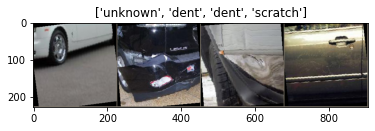

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    valid_loss = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase=='train':
                train_loss.append(epoch_loss)
            if phase=="val":
                valid_loss.append(epoch_loss)
    
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    # plot and save the train and validation line graphs
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet

Instead of random initializaion, the model is initialized using a pretrained network, after which the training proceeds as usual but with a different dataset. Usually the head (or part of it) is also replaced in the network in case there is a different number of outputs. It is common in this method to set the learning rate to a smaller number. This is done because the network is already trained, and only minor changes are required to “finetune” it to a new dataset.

The pretrained resnet18 model is loaded and the final fully connected layer is reset.

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 1.6326 Acc: 0.5166
val Loss: 1.9108 Acc: 0.5893

Epoch 1/24
----------
train Loss: 1.6174 Acc: 0.5371
val Loss: 1.7301 Acc: 0.5536

Epoch 2/24
----------
train Loss: 1.4861 Acc: 0.5419
val Loss: 1.9464 Acc: 0.6190

Epoch 3/24
----------
train Loss: 1.1568 Acc: 0.6445
val Loss: 1.7497 Acc: 0.6429

Epoch 4/24
----------
train Loss: 1.0499 Acc: 0.6714
val Loss: 1.8726 Acc: 0.6071

Epoch 5/24
----------
train Loss: 1.0741 Acc: 0.6761
val Loss: 1.6812 Acc: 0.6369

Epoch 6/24
----------
train Loss: 1.0468 Acc: 0.6872
val Loss: 1.7202 Acc: 0.6488

Epoch 7/24
----------
train Loss: 1.0157 Acc: 0.6603
val Loss: 1.6978 Acc: 0.6548

Epoch 8/24
----------
train Loss: 0.9802 Acc: 0.6872
val Loss: 1.7660 Acc: 0.6488

Epoch 9/24
----------
train Loss: 1.0474 Acc: 0.6777
val Loss: 1.6602 Acc: 0.6488

Epoch 10/24
----------
train Loss: 0.9588 Acc: 0.6935
val Loss: 1.6285 Acc: 0.6548

Epoch 11/24
----------
train Loss: 0.9438 Acc: 0.6983
val Loss: 1.7487 Acc: 0.6250

Ep

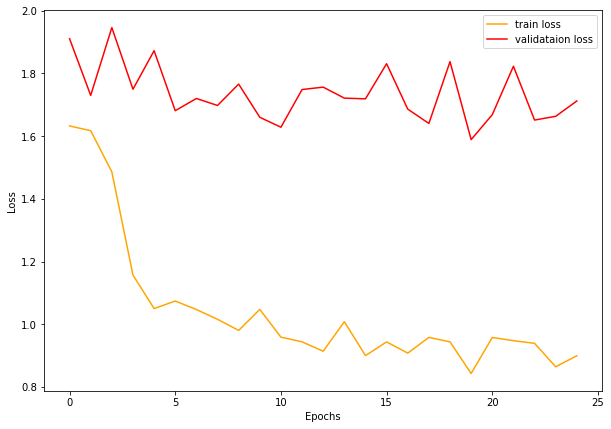

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft, 'submission.h5')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('submission.h5')
model.eval()